# Import Packages

In [1]:
from spiking import SpikingNNModel, Theta

In [2]:
import time
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.8.2


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
sns.set(context = 'talk', style = 'ticks')

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 24
 
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

# Define network parameters 

In [5]:
N = 5000 # number of neurons
T = 50 # total time
dt = 0.0001 # time step
v_reset = -np.pi # reset voltage
v_peak = np.pi # peak voltage
tau_decay = 0.02; # decay time constant
tau_rise = 0.002; # rise time constant
tau_syn = 0.02 # synaptic time constant
alpha = dt # gain on P matrix at initialization
Q = 10**4 # scales the feedback kernel
G = 15 # scales the static recurrent kernel
I_bias = 0 # bias current

t_end_train = round(20/dt) # time step to stop training
p_recurr = 0.1 # (1 - p_recurr) of recurrent weights are randomly set to 0
g = 1 # gain parameter controlling network chaos

print('Total number of time steps: ', T/dt)

Total number of time steps:  500000.0


# Define the target function (Lorenz Attractor)

From https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html

In [6]:
%%time 

# A function that outputs the Lorenz attractor
def lorenz(x, y, z, s, r, b, tc, md):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - md*x*z
    z_dot = md*x*y - b*z
    return tc*(x_dot, y_dot, z_dot)

MD = 70; 
rho = 28;
sigma = 10;
beta = 8/3; 
TC = 1;  

num_steps = round(T/dt)
xs = np.empty((num_steps, 1)) # target, x-dim
ys = np.empty((num_steps, 1)) # target, y-dim
zs = np.empty((num_steps, 1)) # target, z-dim

# Set initial values
xs[0,0], ys[0,0], zs[0,0] = (0.1,0.1,0.1)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps - 1 ):
    x_dot, y_dot, z_dot = lorenz(x = xs[i,0], y = ys[i,0], z = zs[i,0], s = sigma, r = rho, b = beta, tc = TC, md = MD)
    xs[i + 1,0] = xs[i,0] + (x_dot * dt)
    ys[i + 1,0] = ys[i,0] + (y_dot * dt)
    zs[i + 1,0] = zs[i,0] + (z_dot * dt)

CPU times: user 3.75 s, sys: 31.3 ms, total: 3.78 s
Wall time: 5.45 s


In [7]:
target = np.concatenate([xs, ys, zs], axis = 1)
target = tf.cast(target, tf.float32)
input = tf.zeros(target.shape) # set a dummy input of all zeros

print(target.shape)
m = target.shape[1]

(500000, 3)


# Visualize the target

Text(0.5, 1.0, 'X axis')

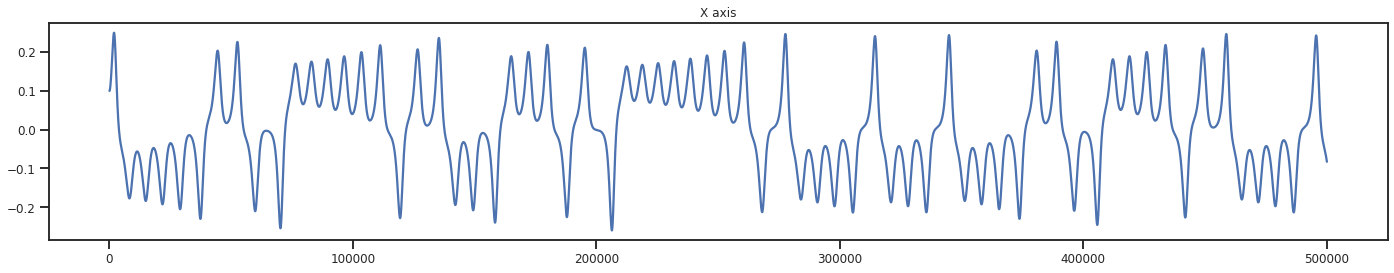

In [8]:
plt.figure(figsize = (24,4))
plt.plot(target[:,0])
plt.title('X axis')

Text(0.5, 1.0, 'Y axis')

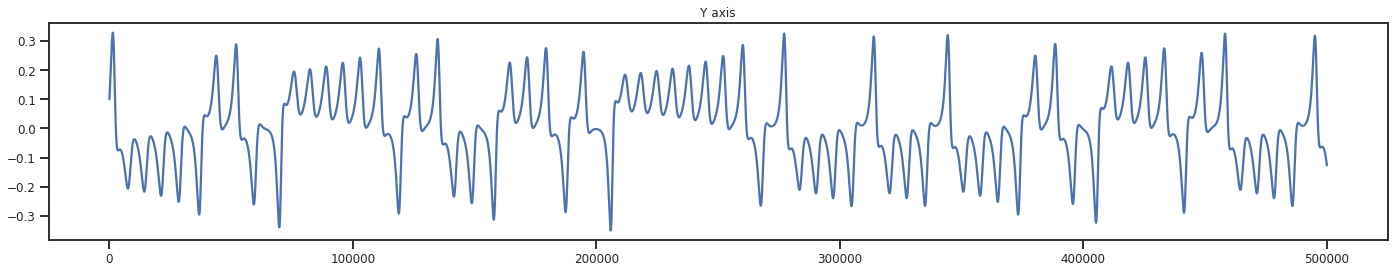

In [9]:
plt.figure(figsize = (24,4))
plt.plot(target[:,1])
plt.title('Y axis')

Text(0.5, 1.0, 'Z axis')

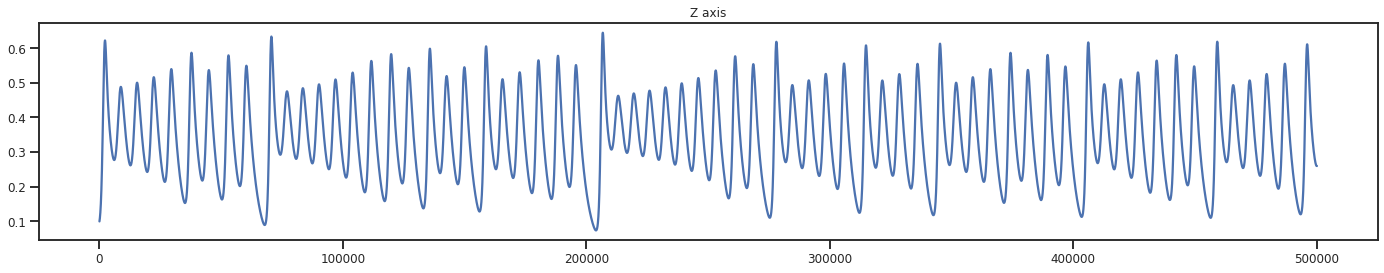

In [10]:
plt.figure(figsize = (24,4))
plt.plot(target[:,2])
plt.title('Z axis')

# Define a custom spiking model class

Only performs FORCE updates every `self.step` number of time steps

In [11]:
class CustomSpikingNNModel(SpikingNNModel):
    def __init__(self, step=50, **kwargs):
        super().__init__(**kwargs)
        self.num_step = tf.Variable(0., trainable=False)
        self.step = step

    def update_kernel_condition(self):
        self.num_step.assign_add(1.0, read_value=False)
        return self.num_step % self.step == 0

# Define custom callbacks

In [12]:
# Tracks the network output during training
class OutputTracking(tf.keras.callbacks.Callback):
    def __init__(self, timesteps, output_size, output_state_idx=-1):
        self.tracking_arr = np.zeros((timesteps, output_size))
        self.output_state_idx = output_state_idx
    
    def on_batch_end(self, batch, logs=None):
        self.tracking_arr[batch] = self.model.force_layer.states[self.output_state_idx][0]

# Define layers and model class and train the model

Define a Theta spiking layer and a spiking model instance. The model trains the layer using data from the first 200,000 time steps of the target. FORCE updates are applied every 50 time steps.

**Note:** This will take approximately 10-20 minutes on Colab CPU

In [13]:
%%time 
tf.random.set_seed(0)

output_tracking = OutputTracking(timesteps=input[:t_end_train].shape[0], 
                                 output_size=m, 
                                 output_state_idx=-1)

Theta_layer = Theta(units=N, 
                    output_size=m,
                    dt=dt,
                    tau_decay=tau_decay,
                    tau_rise=tau_rise, 
                    tau_syn=tau_syn, 
                    v_peak=v_peak, 
                    v_reset=v_reset, 
                    I_bias=I_bias,
                    G=G, 
                    Q=Q, 
                    p_recurr=p_recurr,
                    g=g,
                    seed=0)

spikingmodel = CustomSpikingNNModel(force_layer=Theta_layer, 
                                    alpha_P=alpha,
                                    step=50)
spikingmodel.compile(metrics=["mae" ])
history = spikingmodel.fit(x=input[:t_end_train], 
                           y=target[:t_end_train], 
                           epochs=1, 
                           callbacks=[output_tracking]) 

200000/200000 [==============================] - 922s 5ms/step - mae: 0.0036
CPU times: user 16min 20s, sys: 1min 16s, total: 17min 37s
Wall time: 15min 30s


# Perform inference 

Inference is performed on the last 300,000 time steps of the target

**Note:** This will take approximately 10 minutes on Colab CPU

In [14]:
%%time 
inference = spikingmodel.predict(input[t_end_train:])

CPU times: user 9min 32s, sys: 1min 7s, total: 10min 40s
Wall time: 8min 22s


# Plot the network output during training and inference against the true target

Red vertical line indicates when training stopped

In [15]:
training_inference = np.concatenate([output_tracking.tracking_arr, inference])

Text(0.5, 1.0, 'X axis')

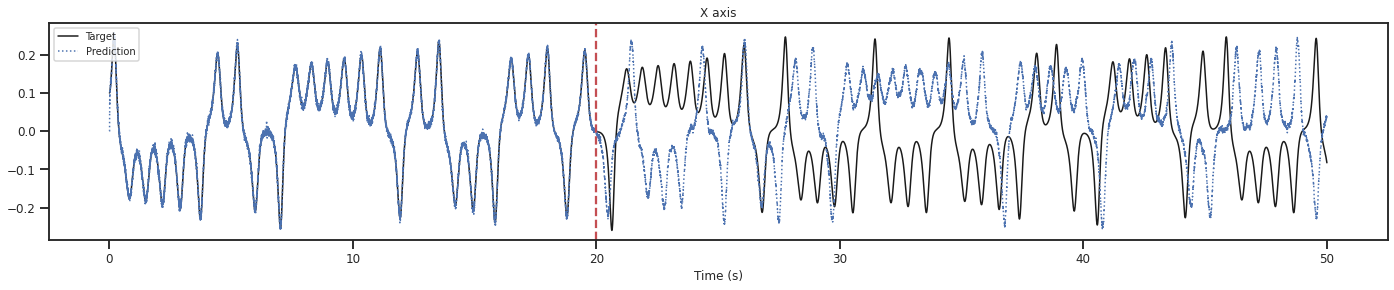

In [16]:
x = np.arange(0,T,dt) 

fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(24,4))
ax1.plot(x, target[:,0], color='k', label='Target', linewidth=1.5)
ax1.plot(x, training_inference[:,0], color='b', label='Prediction',  linewidth=1.5, linestyle=":")
ax1.axvline(x=t_end_train*dt , color='r', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='upper left')
ax1.set_title('X axis')

Text(0.5, 1.0, 'Y axis')

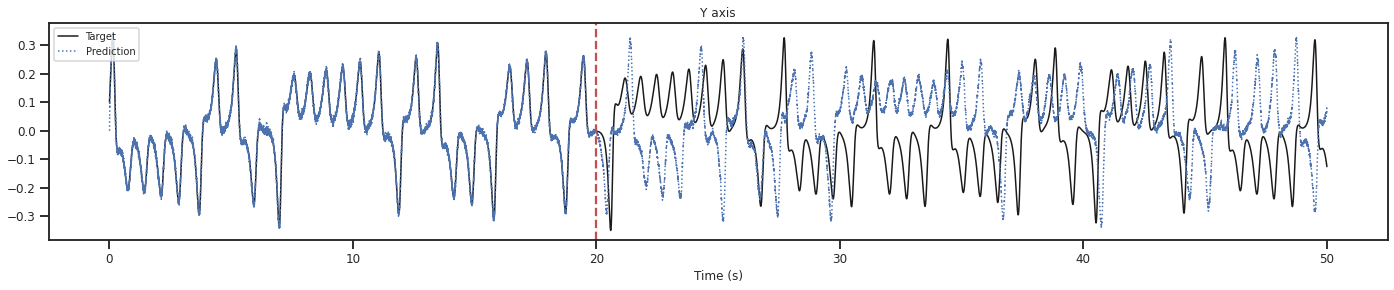

In [17]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(24,4))
ax1.plot(x, target[:,1], color='k', label='Target', linewidth=1.5)
ax1.plot(x, training_inference[:,1], color='b', label='Prediction',  linewidth=1.5, linestyle=":")
ax1.axvline(x=t_end_train*dt , color='r', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.legend(loc = 'upper left')
ax1.set_title('Y axis')

Text(0.5, 1.0, 'Z axis')

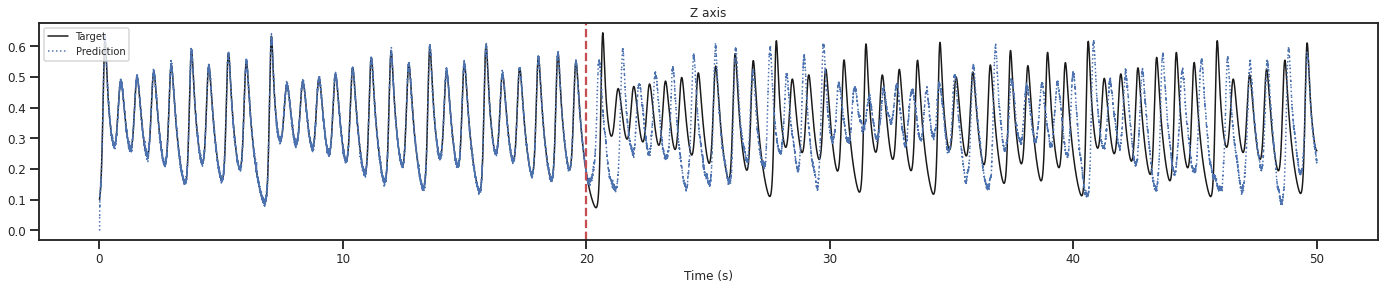

In [18]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(24,4))
ax1.plot(x, target[:,2], color='k', label='Target', linewidth = 1.5)
ax1.plot(x, training_inference[:,2], color='b', label='Prediction',  linewidth=1.5, linestyle=":")
ax1.axvline(x=t_end_train*dt , color='r', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.legend(loc='upper left')
ax1.set_title('Z axis')

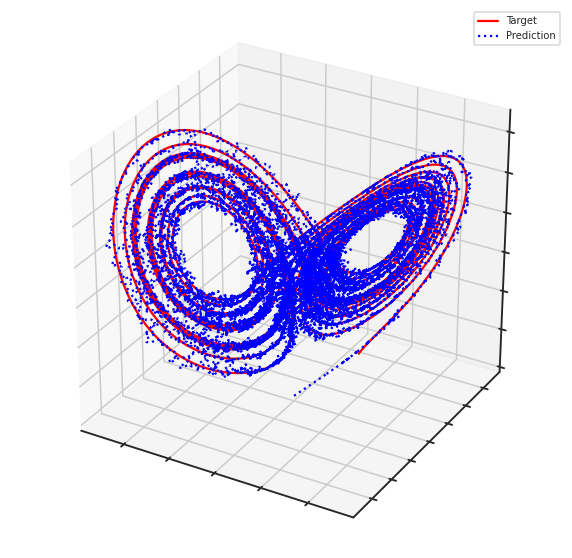

In [19]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.plot3D(target[:t_end_train, 0], 
          target[:t_end_train, 1],
          target[:t_end_train, 2], 
          color='red', 
          label='Target')
ax.plot3D(training_inference[:t_end_train, 0], 
          training_inference[:t_end_train, 1],
          training_inference[:t_end_train, 2], 
          color='blue', 
          linestyle='dotted', 
          label='Prediction')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

ax.legend()

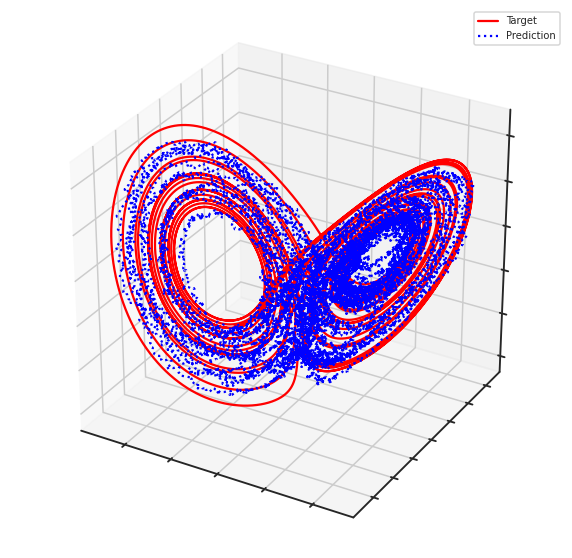

In [20]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.plot3D(target[t_end_train:,0], 
          target[t_end_train:,1],
          target[t_end_train:,2], 
          color='red', 
          label='Target')

ax.plot3D(training_inference[t_end_train:,0], 
          training_inference[t_end_train:,1],
          training_inference[t_end_train:,2],
          color='blue', 
          linestyle='dotted', 
          label='Prediction')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

ax.legend()